In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score


df = pd.read_csv(r"C:\Users\DELL\Desktop\clg competitons\Vihaan8\tremors - Sheet1.csv")


df['movement'] = np.sqrt(df['gx'].diff()**2 + df['gy'].diff()**2 + df['gz'].diff()**2)


df['variance'] = df['movement'].rolling(window=10).var()
df.fillna(0, inplace=True)


slot1 = df['variance'].quantile(0.33)
slot2 = df['variance'].quantile(0.66)

def classify_severity(var):
    if var < slot1:
        return "mild"
    elif var < slot2:
        return "moderate"
    else:
        return "severe"

df['severity'] = df['variance'].apply(classify_severity)


le = LabelEncoder()
df['severity_final'] = le.fit_transform(df['severity'])


df = df.sample(frac=1, random_state=42).reset_index(drop=True)


X = df[['movement', 'variance']]
y = df['severity_final']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Precision Score:", precision_score(y_test, y_pred, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

        mild       1.00      0.98      0.99        51
    moderate       0.98      1.00      0.99        49
      severe       1.00      1.00      1.00        40

    accuracy                           0.99       140
   macro avg       0.99      0.99      0.99       140
weighted avg       0.99      0.99      0.99       140

Accuracy Score: 0.9928571428571429
Precision Score: 0.9929999999999999
Confusion Matrix:
 [[50  1  0]
 [ 0 49  0]
 [ 0  0 40]]


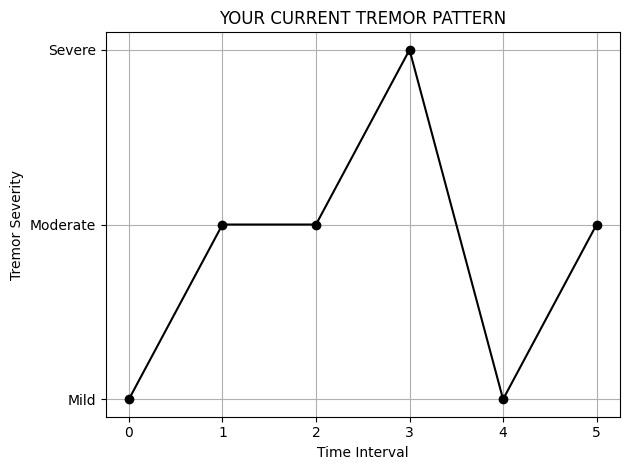

In [5]:
import matplotlib.pyplot as plt
from collections import Counter

label = le.inverse_transform(y_pred)

interval=25

time_group=[]
for i in range(0,len(label),interval):
    time_group.append(label[i:i+interval])

pattern=[]
for i in time_group:
    repeate=Counter(i).most_common(1)[0][0]
    pattern.append(repeate)

dict={"mild":0,"moderate":1,"severe":2}
values= [dict[i] for i in pattern]

plt.plot(range(len(values)),values,marker='o', linestyle='-', color='black')
plt.yticks([0, 1, 2], ["Mild", "Moderate", "Severe"])
plt.title("YOUR CURRENT TREMOR PATTERN")
plt.ylabel("Tremor Severity")
plt.xlabel("Time Interval")
plt.grid(True)
plt.tight_layout()
plt.show()


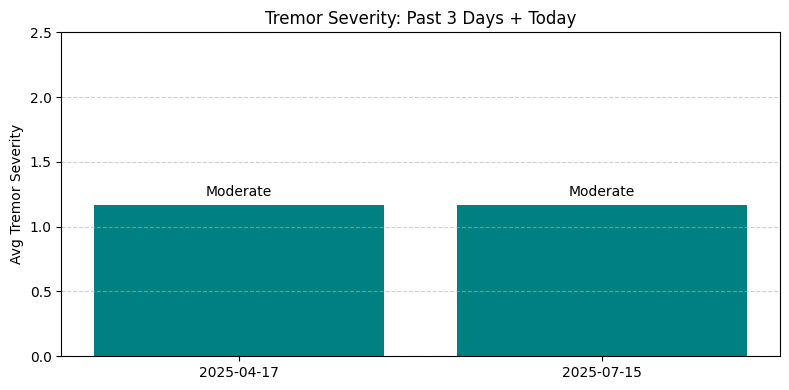

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import json
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, precision_score, confusion_matrix
from collections import Counter


df = pd.read_csv(r"C:\Users\DELL\Desktop\clg competitons\Vihaan8\tremors - Sheet1.csv")

df['movement'] = np.sqrt(df['gx'].diff()**2 + df['gy'].diff()**2 + df['gz'].diff()**2)
df['variance'] = df['movement'].rolling(window=10).var()
df.fillna(0, inplace=True)


slot1 = df['variance'].quantile(0.33)
slot2 = df['variance'].quantile(0.66)

def classify_severity(var):
    if var < slot1:
        return "mild"
    elif var < slot2:
        return "moderate"
    else:
        return "severe"

df['severity'] = df['variance'].apply(classify_severity)
le = LabelEncoder()
df['severity_final'] = le.fit_transform(df['severity'])


X = df[['movement', 'variance']]
y = df['severity_final']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
predicted_labels = le.inverse_transform(y_pred)


interval = 25
pattern = []
for i in range(0, len(predicted_labels), interval):
    chunk = predicted_labels[i:i+interval]
    if chunk.size > 0:
        most_common = Counter(chunk).most_common(1)[0][0]
        pattern.append(most_common)



DATA_FILE = "tremor_log.json"
today = str(datetime.date.today())

# Load old log if available
if os.path.exists(DATA_FILE):
    with open(DATA_FILE, 'r') as f:
        data_log = json.load(f)
else:
    data_log = {}



data_log[today] = pattern

# Keep only last 4 days
recent_dates = sorted(data_log.keys(), reverse=True)[:4]
data_log = {date: data_log[date] for date in sorted(recent_dates)}  # Sort chronologically

# Save updated log
with open(DATA_FILE, 'w') as f:
    json.dump(data_log, f)





severity_map = {'mild': 0, 'moderate': 1, 'severe': 2}
records = {'date': [], 'label': []}

for date, labels in data_log.items():
    records['date'].extend([date] * len(labels))
    records['label'].extend(labels)

df_plot = pd.DataFrame(records)
df_plot['severity'] = df_plot['label'].map(severity_map)
df_grouped = df_plot.groupby('date')['severity'].mean().reset_index()

plt.figure(figsize=(8, 4))
bars = plt.bar(df_grouped['date'], df_grouped['severity'], color='teal')

severity_reverse = {0: 'Mild', 1: 'Moderate', 2: 'Severe'}
for bar, value in zip(bars, df_grouped['severity']):
    label = severity_reverse.get(round(value), '')
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05, label,
             ha='center', va='bottom', fontsize=10)

plt.title("Tremor Severity: Past 3 Days + Today")
plt.ylabel("Avg Tremor Severity")
plt.ylim(0, 2.5)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
